In [1]:
import pandas as pd
import numpy as np 
import torch 
import networkx as nx 
import omnipath as op 
from matplotlib import pyplot as plt 
import copy 
from pypath.utils import mapping

from gsnn.simulate.nx2pyg import nx2pyg

from gsnn.models.GSNN import GSNN
from pypath.utils import mapping
from sklearn.metrics import r2_score

from lincs_gsnn.proc.get_bio_interactions import get_bio_interactions 
from lincs_gsnn.proc.subset import subset_graph

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [51]:
resp_norm = 'zscore'

In [52]:
drug = pd.read_csv('/home/teddy/local/AMLVAE/data/beataml_probit_curve_fits_v4_distr.txt', sep='\t')
aml_clin = pd.read_csv('/home/teddy/local/AMLVAE/data/beataml_clinical_for_inputs.csv')[['gdc_id', 'labId']]
aml_clin = aml_clin.rename(columns={'labId': 'lab_id', 'gdc_id': 'id'})
drug = drug.merge(aml_clin, on='lab_id', how='left')
drug = drug[['id', 'inhibitor', 'auc']].dropna() 

In [53]:
# split inhibitior into two columns 
drug['inhibitor_1'] = drug.inhibitor.str.split(' - ').str[0]
drug['inhibitor_2'] = drug.inhibitor.str.split(' - ').str[1]

drug.head() 


,id,inhibitor,auc,inhibitor_1,inhibitor_2
90,df27ad08-d16e-4a8f-8c31-f137073126d6,A-674563,177.042163,A-674563,NaN
91,df27ad08-d16e-4a8f-8c31-f137073126d6,AKT Inhibitor IV,165.026475,AKT Inhibitor IV,NaN
92,df27ad08-d16e-4a8f-8c31-f137073126d6,AKT Inhibitor X,279.449844,AKT Inhibitor X,NaN
93,df27ad08-d16e-4a8f-8c31-f137073126d6,AMPK Inhibitor,261.982907,AMPK Inhibitor,NaN
94,df27ad08-d16e-4a8f-8c31-f137073126d6,AST-487,285.359954,AST-487,NaN


In [55]:
if resp_norm == 'zscore': 
    # zscore across all drugs 
    drug['response'] = (drug.auc - drug.auc.mean()) / drug.auc.std()
elif resp_norm == 'unit_norm': 
    drug['response'] = (drug.auc - drug.auc.min()) / (drug.auc.max() - drug.auc.min())
elif resp_norm == 'within_drug_zscore': 
    drug['response'] = drug.groupby('inhibitor')['auc'].transform(lambda x: (x - x.mean()) / x.std())
elif resp_norm == 'none': 
    drug['response'] = drug['auc']
else: 
    raise ValueError(f'Invalid response normalization: {resp_norm}')

print(drug.shape)

drug.head()

(68525, 6)


,id,inhibitor,auc,inhibitor_1,inhibitor_2,response
90,df27ad08-d16e-4a8f-8c31-f137073126d6,A-674563,177.042163,A-674563,NaN,-0.022425
91,df27ad08-d16e-4a8f-8c31-f137073126d6,AKT Inhibitor IV,165.026475,AKT Inhibitor IV,NaN,-0.183714
92,df27ad08-d16e-4a8f-8c31-f137073126d6,AKT Inhibitor X,279.449844,AKT Inhibitor X,NaN,1.352220
93,df27ad08-d16e-4a8f-8c31-f137073126d6,AMPK Inhibitor,261.982907,AMPK Inhibitor,NaN,1.117756
94,df27ad08-d16e-4a8f-8c31-f137073126d6,AST-487,285.359954,AST-487,NaN,1.431553


In [12]:
dtis = pd.read_csv('/home/teddy/local/data/targetome_extended-01-23-25.csv', low_memory=False)
dtis = dtis[lambda x: (x.assay_type.isin(['Ki', 'Kd'])) & (x.assay_relation.isin(['=', '<', '<='])) & (x.assay_value < 1000)]

dti_meta = pd.read_csv('../../data/beataml_drugs_for_targetome.csv')[['inhibitor', 'inchi_key']]

dtis = dtis.merge(dti_meta, on='inchi_key', how='inner')
print(dtis.shape)
dtis.head() 

(8896, 9)


,pubchem_cid,inchi_key,uniprot_id,pubmed_id,database,assay_type,assay_relation,assay_value,inhibitor
0,3501,VWVYILCFSYNJHF-UHFFFAOYSA-N,O00444,23829549.0,pubchem_bioassay,Ki,=,3.40,Go6976
1,3503,QBKSWRVVCFFDOT-UHFFFAOYSA-N,P10415,17034116.0,pubchem_bioassay,Ki,=,320.00,AT-101
2,3503,QBKSWRVVCFFDOT-UHFFFAOYSA-N,P10415,17552510.0,pubchem_bioassay,Ki,=,170.00,AT-101
3,3503,QBKSWRVVCFFDOT-UHFFFAOYSA-N,P10415,18040043.0,pubchem_bioassay,Ki,=,467.74,AT-101
4,3503,QBKSWRVVCFFDOT-UHFFFAOYSA-N,P10415,20925433.0,pubchem_bioassay,Ki,=,320.00,AT-101


In [13]:
drug_candidates = drug.inhibitor_1.str.lower().unique().tolist() + drug.inhibitor_2.str.lower().unique().tolist()
len(drug_candidates)

dtis = dtis[lambda x: x.inhibitor.str.lower().isin(drug_candidates)]
dtis.head() 

,pubchem_cid,inchi_key,uniprot_id,pubmed_id,database,assay_type,assay_relation,assay_value,inhibitor
0,3501,VWVYILCFSYNJHF-UHFFFAOYSA-N,O00444,23829549.0,pubchem_bioassay,Ki,=,3.40,Go6976
1,3503,QBKSWRVVCFFDOT-UHFFFAOYSA-N,P10415,17034116.0,pubchem_bioassay,Ki,=,320.00,AT-101
2,3503,QBKSWRVVCFFDOT-UHFFFAOYSA-N,P10415,17552510.0,pubchem_bioassay,Ki,=,170.00,AT-101
3,3503,QBKSWRVVCFFDOT-UHFFFAOYSA-N,P10415,18040043.0,pubchem_bioassay,Ki,=,467.74,AT-101
4,3503,QBKSWRVVCFFDOT-UHFFFAOYSA-N,P10415,20925433.0,pubchem_bioassay,Ki,=,320.00,AT-101


In [14]:
drugspace = dtis.inhibitor.unique()
len(drugspace)

128

In [15]:
targ_candidates = dtis.uniprot_id.unique() 
len(targ_candidates)

507

In [16]:
bio_names, bio_df = get_bio_interactions(undirected=False, include_mirna=True, include_extra=True)
bio_df.head() 

# of translation (RNA->PROTEIN) edges: 5057


,source,target,edge_type
0,PROTEIN__P01106,RNA__O14746,dorothea
1,PROTEIN__P84022,RNA__P05412,dorothea
2,PROTEIN__Q13485,RNA__P05412,dorothea
3,PROTEIN__P08047,RNA__P04075,dorothea
4,PROTEIN__P04637,RNA__P08069,dorothea


In [17]:
dti_df = dtis.assign(source=['DRUG__' + x for x in dtis.inhibitor.str.lower()],
                                        target=['PROTEIN__' + x for x in dtis.uniprot_id],
                                        edge_type='dti')[['source', 'target', 'edge_type']].drop_duplicates()[['source', 'target', 'edge_type']]
dti_df.head()

,source,target,edge_type
0,DRUG__go6976,PROTEIN__O00444,dti
1,DRUG__at-101,PROTEIN__P10415,dti
15,DRUG__at-101,PROTEIN__P15121,dti
16,DRUG__at-101,PROTEIN__Q07817,dti
25,DRUG__at-101,PROTEIN__Q07820,dti


In [18]:
drugspace = dti_df.source.unique() 

In [19]:
protspace = [x.split('__')[1] for x in np.unique(bio_df.source.tolist() + bio_df.target.tolist()).tolist() if x.split('__')[0] == 'PROTEIN']
len(protspace)

11209

In [20]:
pathways = pd.read_csv('../../data/UniProt2Reactome.txt', sep='\t', header=None)
pathways.columns = ['uniprot_id', 'reactome_id', 'url', 'name', '???', 'organism']
pathways = pathways[lambda x: (x.organism == 'Homo sapiens') & (x.uniprot_id.isin(protspace))]
pathways = pathways.assign(source = ['PROTEIN__' + x for x in pathways.uniprot_id],
                           target = ['PATHWAY__' + x for x in pathways.name], 
                           edge_type = 'reactome')
path_df = pathways[['source', 'target', 'edge_type']]
pathspace = (path_df.groupby('target').count()[['source']] > 25)[lambda x: x.source].index
path_df = path_df[lambda x: x.target.isin(pathspace)]
pathspace = path_df.target.unique() 
path_df.head() 

,source,target,edge_type
71903,PROTEIN__A0AVI4,PATHWAY__E3 ubiquitin ligases ubiquitinate tar...,reactome
72311,PROTEIN__A0MZ66,PATHWAY__Recycling pathway of L1,reactome
72438,PROTEIN__A1A4S6,PATHWAY__RHOA GTPase cycle,reactome
72439,PROTEIN__A1A4S6,PATHWAY__CDC42 GTPase cycle,reactome
72440,PROTEIN__A1A4S6,PATHWAY__RAC1 GTPase cycle,reactome


In [21]:
edgedf = pd.concat([dti_df, bio_df, path_df], axis=0)

In [22]:
G = nx.DiGraph()

for i,row in edgedf.iterrows(): 
    G.add_edge(row.source, row.target) 

len(G)

19506

In [23]:
G = subset_graph(G, depth=5, roots=drugspace, leafs=pathspace) 

In [35]:
drugspace = [d for d in G.nodes() if d.startswith('DRUG__')]
print('drugspace',len(drugspace))

protspace = [p for p in G.nodes() if p.startswith('PROTEIN__')] 
print('protspace', len(protspace))

rnaspace = [r for r in G.nodes() if r.startswith('RNA__')]
print('rnaspace', len(rnaspace))

pathspace = [p for p in G.nodes() if p.startswith('PATHWAY__')]
print('pathspace',len(pathspace))

print()
print('# nodes',len(G.nodes()))
print('# edges', len(G.edges()))

drugspace 128
protspace 6841
rnaspace 3153
pathspace 484

# nodes 10606
# edges 119565


In [36]:
uniprot_rnaspace = [x.split('__')[1] for x in rnaspace] 

In [37]:
uni2symb = {'uniprot': [] , 'gene_symbol': []}
failed = 0
for i,uni in enumerate(uniprot_rnaspace):
    print(f'Processing {i+1}/{len(uniprot_rnaspace)} | [failed: {failed}/{i}]', end='\r')

    try: 
        mapped = mapping.map_name(uni, id_type='uniprot', target_id_type='genesymbol')
        for x in mapped:
            uni2symb['uniprot'].append(uni)
            uni2symb['gene_symbol'].append(x)

    except: 
        failed += 1

uni2symb = pd.DataFrame(uni2symb)
uni2symb = uni2symb.drop_duplicates()
uni2symb.head()

,uniprot,gene_symbol
0,O14746,TERT
1,P05412,JUN
2,P04075,ALDOA
3,P08069,IGF1R
4,P20248,CCNA2


In [38]:
aml_expr = pd.read_csv('/home/teddy/local/AMLVAE/data/aml_full_manuscript.csv')[['id', 'gene_name', 'fpkm_unstranded']].rename(columns={'fpkm_unstranded': 'FPKM'}).assign(id_type='gdc_id')
aml_expr = aml_expr.dropna()
aml_expr = aml_expr.groupby(['id', 'gene_name', 'id_type']).max().reset_index() # use max to resolve duplicates (usually a zero and a non-zero)
aml_expr.head()

,id,gene_name,id_type,FPKM
0,001454b2-aff9-4659-85a6-73fb8092589a,5S_rRNA,gdc_id,1.2517
1,001454b2-aff9-4659-85a6-73fb8092589a,5_8S_rRNA,gdc_id,0.2182
2,001454b2-aff9-4659-85a6-73fb8092589a,7SK,gdc_id,0.0000
3,001454b2-aff9-4659-85a6-73fb8092589a,A1BG,gdc_id,0.1161
4,001454b2-aff9-4659-85a6-73fb8092589a,A1BG-AS1,gdc_id,0.5899


In [39]:
aml_expr = aml_expr[lambda x: x.gene_name.isin(uni2symb.gene_symbol.unique())]

2693


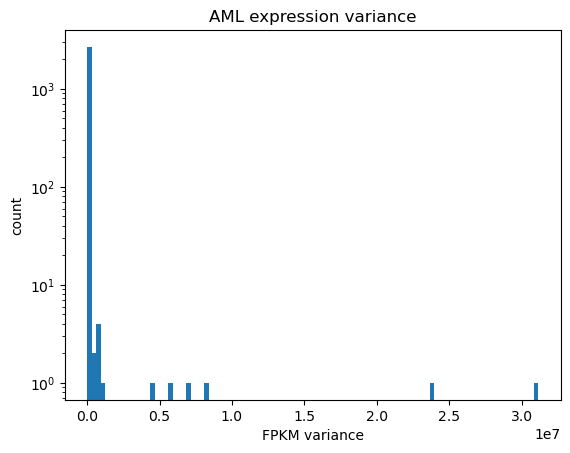

In [40]:
gene_vars = aml_expr.groupby('gene_name')[['FPKM']].var()

gene_vars = gene_vars[(gene_vars.FPKM > np.quantile(gene_vars.FPKM, 0.1))]
print(len(gene_vars))

plt.figure() 
plt.hist(gene_vars.FPKM, bins=100)
plt.yscale('log')
plt.xlabel('FPKM variance')
plt.ylabel('count')
plt.title('AML expression variance')
plt.show()


In [41]:
# convert long to wide 
aml_expr = aml_expr.pivot(index='id', columns='gene_name', values='FPKM')
aml_expr.head()

gene_name,A2M,AAK1,ABCA1,ABCB1,ABCB9,ABCC1,ABCC2,ABCC3,ABCC4,ABCE1,...,ZNF496,ZNF519,ZNF567,ZNF638,ZNF655,ZNF746,ZNRF1,ZNRF2,ZWINT,ZZZ3
id,,,,,,,,,,,,,,,,,,,,,
001454b2-aff9-4659-85a6-73fb8092589a,0.2835,4.8988,1.2838,6.2756,0.2670,55.0140,1.1512,0.8211,6.6233,15.5986,...,10.2525,0.7795,3.0614,18.7337,13.1085,7.7133,9.1171,11.5506,9.3356,7.8507
002cacd9-c03b-4526-a380-0701f41c4a9e,0.2421,4.2181,1.6977,7.7769,0.2133,32.3807,0.3674,0.0328,1.1889,8.4822,...,20.4911,0.3392,1.0287,8.1194,14.9641,6.7146,5.4879,5.4077,2.7447,5.0948
006e5777-2603-4db7-a1d6-8c8085c5e3e5,0.0855,8.3504,2.5728,1.1438,0.1504,21.4961,1.3048,0.0992,3.8013,20.2656,...,8.6605,0.6603,2.6791,21.1363,18.9931,8.7434,7.3419,11.8345,4.5140,9.9588
00870f33-cab3-4c23-bd0d-8903a5a9789e,0.1630,3.4954,20.6901,8.1900,0.0504,45.3537,0.6767,0.1794,1.2799,9.2415,...,10.8665,0.1044,1.4932,6.0265,18.6320,10.2084,4.2422,4.4257,1.9929,4.1526
00b535f6-064a-4dcf-ab14-387a54eedeee,0.1299,4.7062,0.4717,0.2292,0.2151,12.3788,0.2276,0.5182,1.2992,6.9528,...,3.3199,0.1614,0.2817,5.7622,7.1574,5.1646,4.6872,5.8232,20.4846,1.7756


In [42]:
#  scale expression 0-1 
aml_expr = aml_expr - aml_expr.min(axis=0)
aml_expr = aml_expr / aml_expr.max(axis=0)
aml_expr.head() 

gene_name,A2M,AAK1,ABCA1,ABCB1,ABCB9,ABCC1,ABCC2,ABCC3,ABCC4,ABCE1,...,ZNF496,ZNF519,ZNF567,ZNF638,ZNF655,ZNF746,ZNRF1,ZNRF2,ZWINT,ZZZ3
id,,,,,,,,,,,,,,,,,,,,,
001454b2-aff9-4659-85a6-73fb8092589a,0.019602,0.153196,0.022450,0.150770,0.171627,0.563218,0.455209,0.057692,0.058905,0.400087,...,0.423122,0.397606,0.581239,0.463010,0.254587,0.266200,0.506775,0.594698,0.154512,0.469403
002cacd9-c03b-4526-a380-0701f41c4a9e,0.016704,0.127755,0.029869,0.187019,0.133209,0.319925,0.135617,0.002305,0.010259,0.194231,...,0.874676,0.156966,0.184328,0.176191,0.303268,0.217636,0.300238,0.239632,0.040281,0.270951
006e5777-2603-4db7-a1d6-8c8085c5e3e5,0.005741,0.282196,0.045554,0.026861,0.088210,0.202922,0.517839,0.006970,0.033644,0.535090,...,0.352909,0.332459,0.506590,0.527933,0.408968,0.316292,0.405749,0.611108,0.070946,0.621207
00870f33-cab3-4c23-bd0d-8903a5a9789e,0.011166,0.100745,0.370290,0.196993,0.016669,0.459376,0.261733,0.012605,0.011074,0.216195,...,0.450201,0.028639,0.275028,0.119637,0.399495,0.387533,0.229346,0.182871,0.027251,0.203104
00b535f6-064a-4dcf-ab14-387a54eedeee,0.008849,0.145998,0.007894,0.004778,0.134497,0.104917,0.078614,0.036410,0.011247,0.149990,...,0.117372,0.059791,0.038467,0.112495,0.098462,0.142262,0.254671,0.263648,0.347743,0.031936


In [43]:
symb2uni = uni2symb.set_index('gene_symbol').uniprot.to_dict()

aml_expr.columns = [f'EXPR__{symb2uni[x]}' for x in aml_expr.columns] 

In [44]:
overlap_unis = set([x.split('__')[1] for x in aml_expr.columns.tolist()]).intersection(set([x.split('__')[1] for x in rnaspace])) 
input_expr = [f'EXPR__{x}' for x in overlap_unis] 
len(input_expr)

2962

In [45]:
aml_expr = aml_expr[input_expr]

In [46]:
input_nodes = aml_expr.columns.tolist() + drugspace 
function_nodes = protspace + rnaspace + pathspace
output_nodes = ['OUT_AUC']

G = G.copy() # unfreeze graph 

# add expr edges 
for i,uni in enumerate(overlap_unis):
    G.add_edge(f'EXPR__{uni}', f'RNA__{uni}')

# add output edge (from pathways to output) 
for p in pathspace:
    G.add_edge(p, 'OUT_AUC') 

In [47]:
data = nx2pyg(G, input_nodes=input_nodes, function_nodes=function_nodes, output_nodes=output_nodes)

In [67]:
included_drugs = [x.split('__')[1] for x in drugspace] 
included_ids = aml_expr.index.unique().tolist() 

drug = drug[drug.inhibitor_1.str.lower().isin(included_drugs) & drug.id.isin(included_ids)] 

# also include combination agents (nan or included drugs)
drug = drug[drug.inhibitor_2.isna() | drug.inhibitor_2.str.lower().isin(included_drugs)]

# assign partitions 
# prior MDS ids should be the test set 
# train/val should be randomly splt
prior_mds_ids = pd.read_csv('/home/teddy/local/AMLVAE/data/beataml_clinical_for_inputs.csv')[lambda x: x.priorMDS == 'y'].gdc_id.unique().tolist()
drug = drug.assign(partition= np.random.choice(['train', 'val'], size=len(drug), p=[0.85, 0.15]))
drug['partition'] = ['test' if x in prior_mds_ids else y for x,y in zip(drug.id, drug.partition)]

print('# train:', len(drug[drug.partition == 'train']))
print('# val:', len(drug[drug.partition == 'val']))
print('# test:', len(drug[drug.partition == 'test']))



print(drug.shape)

# train: 30696
# val: 5486
# test: 3503
(39685, 7)


In [68]:
torch.save(data, '../proc/graph.pt')
aml_expr.to_csv('../proc/aml_expr.csv')
drug.to_csv('../proc/resp.csv')